# PAMAP2 - CNN
- pytorch
- 피험자 별로 데이터 split(subject-based split)
- 성능 저하
- cnn 모델을 한 레이어 추가, linear interpolation 대신 ffill, bfill 사용, early stopping의 patience를 50으로 늘림 등의 방법을 써봤지만 성능이 더 저하됨
- subject-based split을 하면 겪는 문제라고 함 (완전 처음 보는 데이터이기 때문)


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torchsummary import summary

In [ ]:
# !pip install torchsummary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI_data/PAMAP2/PAMAP2_integrated_data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3850505 entries, 0 to 3850504
Data columns (total 55 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        float64
 1   activityID       float64
 2   heart_rate       float64
 3   hand_temp        float64
 4   hand_acc_16g_x   float64
 5   hand_acc_16g_y   float64
 6   hand_acc_16g_z   float64
 7   hand_acc_6g_x    float64
 8   hand_acc_6g_y    float64
 9   hand_acc_6g_z    float64
 10  hand_gyro_x      float64
 11  hand_gyro_y      float64
 12  hand_gyro_z      float64
 13  hand_mag_x       float64
 14  hand_mag_y       float64
 15  hand_mag_z       float64
 16  hand_orient_1    float64
 17  hand_orient_2    float64
 18  hand_orient_3    float64
 19  hand_orient_4    float64
 20  chest_temp       float64
 21  chest_acc_16g_x  float64
 22  chest_acc_16g_y  float64
 23  chest_acc_16g_z  float64
 24  chest_acc_6g_x   float64
 25  chest_acc_6g_y   float64
 26  chest_acc_6g_z   float64
 27  chest_gyro_x

In [ ]:
df = df.drop(columns=['timestamp', 'heart_rate', 'hand_temp', 'hand_acc_6g_x', 'hand_acc_6g_y', 'hand_acc_6g_z',
                     'hand_orient_1', 'hand_orient_2', 'hand_orient_3', 'hand_orient_4',
                     'chest_temp', 'chest_acc_6g_x', 'chest_acc_6g_y', 'chest_acc_6g_z',
                     'chest_orient_1', 'chest_orient_2', 'chest_orient_3', 'chest_orient_4',
                     'ankle_temp', 'ankle_acc_6g_x', 'ankle_acc_6g_y', 'ankle_acc_6g_z',
                     'ankle_orient_1', 'ankle_orient_2', 'ankle_orient_3', 'ankle_orient_4'])

In [ ]:
df.isna().sum()

,0
activityID,0
hand_acc_16g_x,14338
hand_acc_16g_y,14338
hand_acc_16g_z,14338
hand_gyro_x,14338
hand_gyro_y,14338
hand_gyro_z,14338
hand_mag_x,14338
hand_mag_y,14338
hand_mag_z,14338


In [ ]:
activity_mapping = {
    1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6,
    12: 7, 13: 8, 16: 9, 17: 10, 24: 11
}
df = df[df["activityID"].isin(activity_mapping.keys())]

# Handle NaN values by activity
df_list = []
for activity_id in df['activityID'].unique():
    activity_df = df[df['activityID'] == activity_id].copy()
    # linear interpolation
    activity_df = activity_df.interpolate(method='linear')
    # NaN 값이 남아 있을 때 forward/backward fill 처리
    activity_df = activity_df.fillna(method='ffill').fillna(method='bfill')
    df_list.append(activity_df)

df_processed = pd.concat(df_list, ignore_index=True)

/tmp/ipython-input-2756959744.py:12: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  activity_df = activity_df.interpolate(method='linear')
/tmp/ipython-input-2756959744.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  activity_df = activity_df.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-2756959744.py:12: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  activity_df = activity_df.interpolate(method='linear')
/tmp/ipython-input-2756959744.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  activity_df = activity_df.fillna(method='ffill').f

In [ ]:
df['activityID'].value_counts()

,count
activityID,
4.0,238761
17.0,238690
1.0,192523
3.0,189931
7.0,188107
2.0,185188
16.0,175353
6.0,164600
12.0,117216


In [ ]:
scaler = MinMaxScaler()
features_to_scale = df_processed.columns.drop(['subject', 'activityID'])
df_processed[features_to_scale] = scaler.fit_transform(df_processed[features_to_scale])

In [ ]:
TIME_STEPS = 100 # 1 sec (100Hz sampling)
STEPS = 50       # 50% overlap

def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [ ]:
train_df = df_processed[~df_processed['subject'].isin(['Protocol_subject101', 'Protocol_subject102'])]
val_df = df_processed[df_processed['subject'] == 'Protocol_subject101']
test_df = df_processed[df_processed['subject'] == 'Protocol_subject102']

print(f"Train subjects: {train_df['subject'].unique()}")
print(f"Val subjects: {val_df['subject'].unique()}")
print(f"Test subjects: {test_df['subject'].unique()}")

Train subjects: ['Protocol_subject103' 'Protocol_subject104' 'Protocol_subject105'
 'Protocol_subject106' 'Protocol_subject107' 'Protocol_subject108'
 'Protocol_subject109']
Val subjects: ['Protocol_subject101']
Test subjects: ['Protocol_subject102']


In [ ]:
def prepare_data_split(df):
    X = df.drop(columns=['activityID', 'subject'])
    y = df['activityID'].map(activity_mapping)
    X_seq, y_seq = create_dataset(X, y, TIME_STEPS, STEPS)
    return X_seq, y_seq.flatten()

In [ ]:
X_train, y_train = prepare_data_split(train_df)
X_val, y_val = prepare_data_split(val_df)
X_test, y_test = prepare_data_split(test_df)

print(f"\nSubject-based data split:")
print(f"Train set size: X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"Validation set size: X_val.shape = {X_val.shape}, y_val.shape = {y_val.shape}")
print(f"Test set size: X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")


Subject-based data split:
Train set size: X_train.shape = (28590, 100, 27), y_train.shape = (28590,)
Validation set size: X_val.shape = (4998, 100, 27), y_val.shape = (4998,)
Test set size: X_test.shape = (5265, 100, 27), y_test.shape = (5265,)


In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_dataset = PAMAP2Dataset(X_train, y_train)
val_dataset = PAMAP2Dataset(X_val, y_val)
test_dataset = PAMAP2Dataset(X_test, y_test)

In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# CNN-only Model
class PAMAP2_CNN(nn.Module):
    def __init__(self, input_features, num_classes):
        super(PAMAP2_CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(input_features, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.MaxPool1d(2),

            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Input shape: (batch_size, seq_len, features)
        # Conv1d expects: (batch_size, features, seq_len)
        x = x.transpose(1, 2)

        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        x = x.squeeze(-1)  # Remove last dimension: (batch_size, 512, 1) -> (batch_size, 512)
        x = self.classifier(x)

        return x

In [ ]:
input_features = X_train.shape[2]
num_classes = len(np.unique(y_train))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = PAMAP2_CNN(input_features, num_classes).to(device)

summary(model, input_size=(TIME_STEPS, input_features))

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 100]           8,704
              ReLU-2              [-1, 64, 100]               0
       BatchNorm1d-3              [-1, 64, 100]             128
            Conv1d-4             [-1, 128, 100]          24,704
              ReLU-5             [-1, 128, 100]               0
       BatchNorm1d-6             [-1, 128, 100]             256
           Dropout-7             [-1, 128, 100]               0
         MaxPool1d-8              [-1, 128, 50]               0
            Conv1d-9              [-1, 256, 50]          98,560
             ReLU-10              [-1, 256, 50]               0
      BatchNorm1d-11              [-1, 256, 50]             512
          Dropout-12              [-1, 256, 50]               0
        MaxPool1d-13              [-1, 256, 25]               0
           Conv1d-14

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=1e-5)

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
num_epochs = 100
best_val_loss = float('inf')
patience = 20
patience_counter = 0

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

print("Starting training...")
for epoch in range(num_epochs):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'PAMAP2_CNN_best.pth')
        print(f'New best validation loss: {best_val_loss:.2f}%')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

print("Training completed!")

Starting training...
Epoch [1/100]
Train Loss: 0.5210, Train Acc: 85.33%
Val Loss: 2.7399, Val Acc: 46.78%
--------------------------------------------------
New best validation loss: 2.74%
Epoch [2/100]
Train Loss: 0.2404, Train Acc: 93.03%
Val Loss: 3.1204, Val Acc: 38.98%
--------------------------------------------------
Epoch [3/100]
Train Loss: 0.1821, Train Acc: 94.65%
Val Loss: 2.4075, Val Acc: 56.76%
--------------------------------------------------
New best validation loss: 2.41%
Epoch [4/100]
Train Loss: 0.1541, Train Acc: 95.51%
Val Loss: 2.4540, Val Acc: 55.94%
--------------------------------------------------
Epoch [5/100]
Train Loss: 0.1273, Train Acc: 96.20%
Val Loss: 3.9663, Val Acc: 49.68%
--------------------------------------------------
Epoch [6/100]
Train Loss: 0.1175, Train Acc: 96.34%
Val Loss: 2.6740, Val Acc: 55.72%
--------------------------------------------------
Epoch [7/100]
Train Loss: 0.0998, Train Acc: 96.95%
Val Loss: 2.8873, Val Acc: 55.68%
-------

In [ ]:
model.load_state_dict(torch.load('PAMAP2_CNN_best.pth'))

print("\nFinal Evaluation:")
train_loss, train_acc = validate_epoch(model, train_loader, criterion, device)
print(f"Training accuracy: {train_acc:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f"Test accuracy: {test_acc:.2f}%")
print(f"Test loss: {test_loss:.4f}")


Final Evaluation:
Training accuracy: 90.41%
Training loss: 0.2983
Test accuracy: 62.45%
Test loss: 1.2640


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9736    0.9466    0.9599       468
           1     0.4139    0.8770    0.5624       447
           2     0.2161    0.0996    0.1364       512
           3     0.7803    0.2673    0.3982       651
           4     0.9942    0.9189    0.9551       185
           5     0.8618    0.9442    0.9011       502
           6     0.5355    0.9276    0.6790       594
           7     0.4328    0.4179    0.4252       347
           8     0.6053    0.1513    0.2421       304
           9     0.4443    0.6932    0.5415       414
          10     0.9406    0.8510    0.8935       577
          11     0.8533    0.2424    0.3776       264

    accuracy                         0.6245      5265
   macro avg     0.6710    0.6114    0.5893      5265
weighted avg     0.6610    0.6245    0.5931      5265



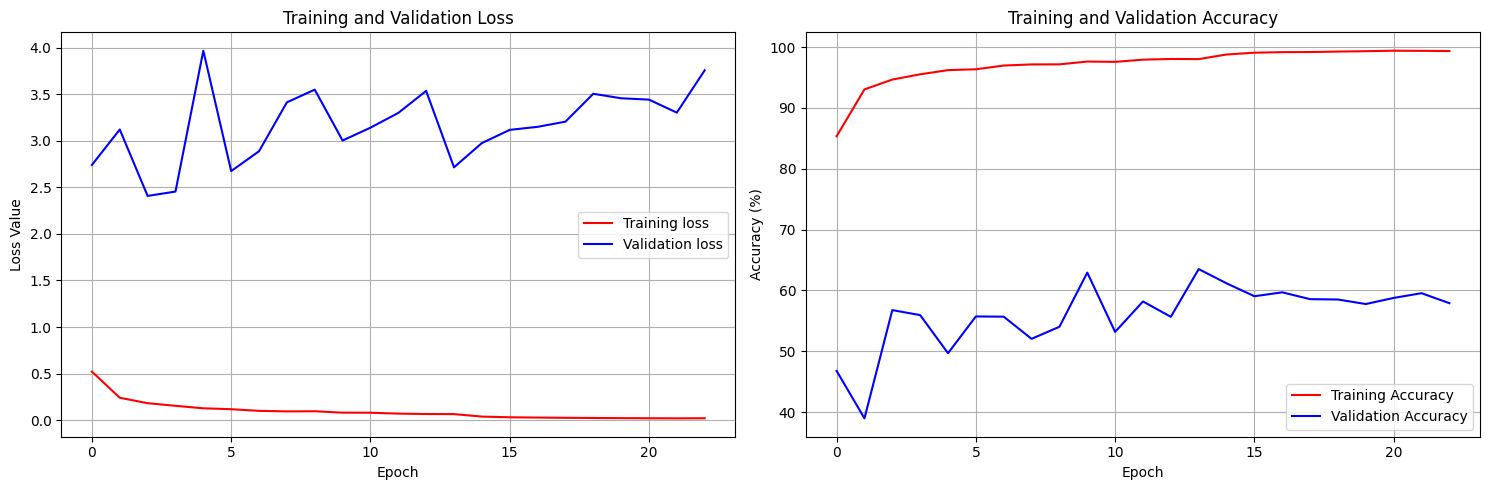

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'r', label='Training loss')
plt.plot(val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'r', label='Training Accuracy')
plt.plot(val_accuracies, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

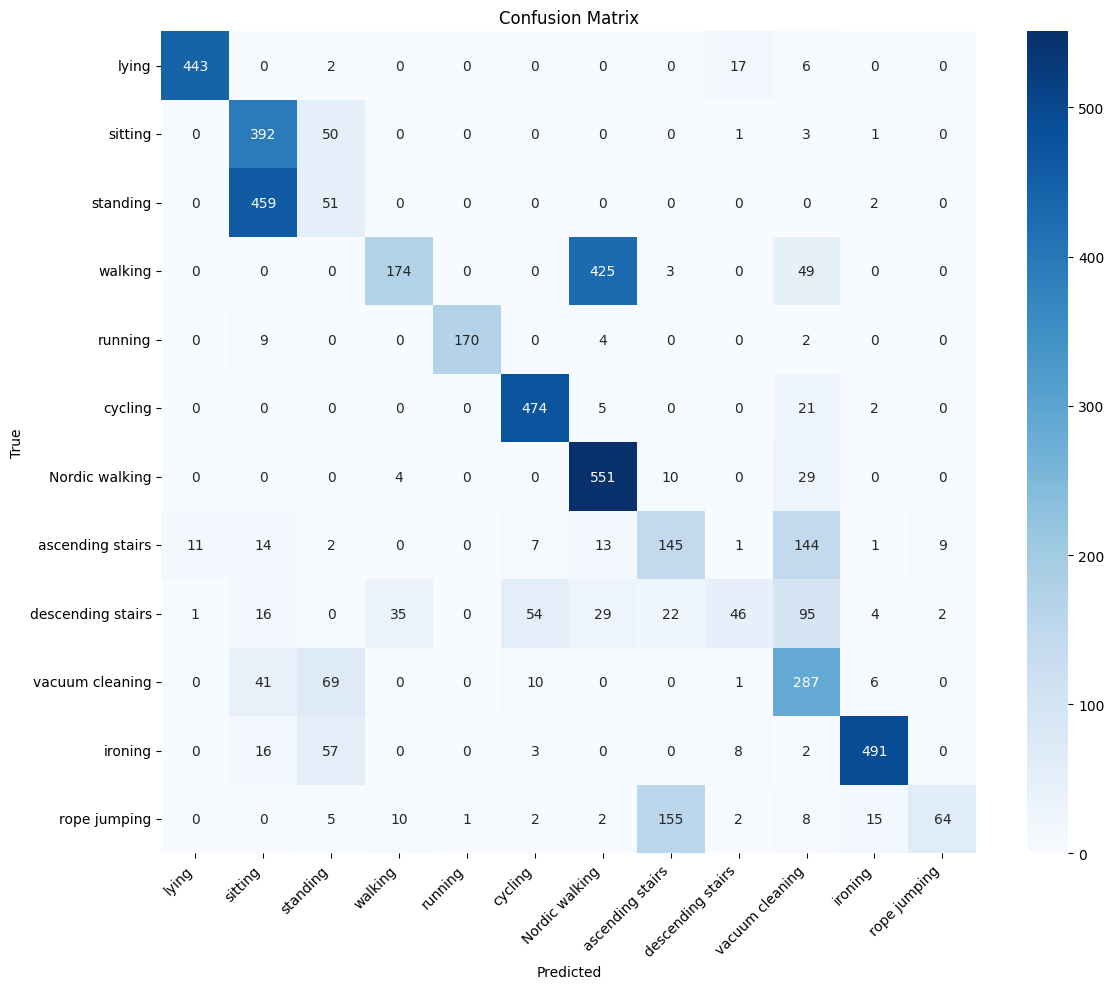

In [ ]:
LABELS = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling',
          'Nordic walking', 'ascending stairs', 'descending stairs',
          'vacuum cleaning', 'ironing', 'rope jumping']

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

if num_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:num_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:num_classes], rotation=0)

plt.tight_layout()
plt.show()